In [ ]:
"""
Author @Sippapas Sukpholtham
Master's Student in Mechanical and Aerospace Engineering
University of Florida
Dec, 2022

"""

#### Importing all necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn


# from CNN.CNN_2 import CNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


#### Loading Data

In [2]:
# Loading data
# raw_data = np.genfromtxt('data_for_training.csv', delimiter=",", skip_header=1)
raw_data = np.load('data_for_training.npy')
print(raw_data.shape)

data = raw_data[:,:-1]
print(data.shape)

labels = raw_data[:,-1]
print(labels.shape)

(13600, 785)
(13600, 784)
(13600,)


The source of data

https://www.kaggle.com/datasets/xainano/handwrittenmathsymbols?resource=download

#### Reshaping and converting the data from numpy to tensor

In [3]:
# Reshaping the dimension before inputting into Neural Network
data = data.reshape(data.shape[0], 28, 28)
data = np.array(data, dtype='int64')
labels = np.array(labels, dtype='int64')
# Convert type of data from numpy to tensor
data = torch.from_numpy(data)
labels = torch.from_numpy(labels)

In [4]:
data.shape

torch.Size([13600, 28, 28])

#### Splitting the whole data to training set and test set for training and validation

In [5]:
# Splitting the whole data to training set and test set for training and validation
x_train, x_vali, t_train, t_vali = train_test_split(data, labels, test_size=0.2, shuffle=True)

#### Checking the balance of data

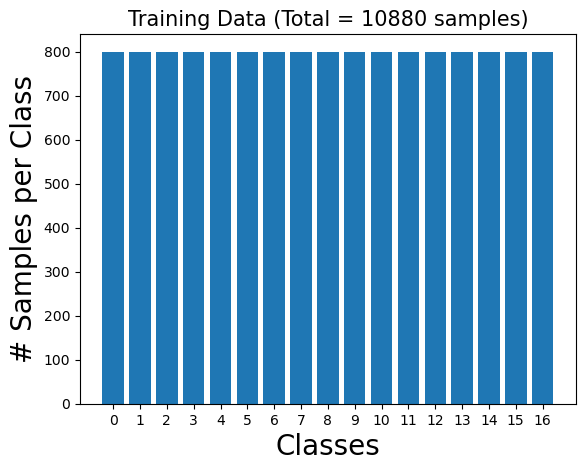

In [6]:
# Counting number samples per class
vals, counts = np.unique(labels, return_counts=True)

plt.bar(vals, counts)
plt.xticks(range(17),range(17))
plt.xlabel('Classes',size=20)
plt.ylabel('# Samples per Class', size=20)
plt.title('Training Data (Total = '+str(x_train.shape[0])+' samples)',size=15);

tensor(12)


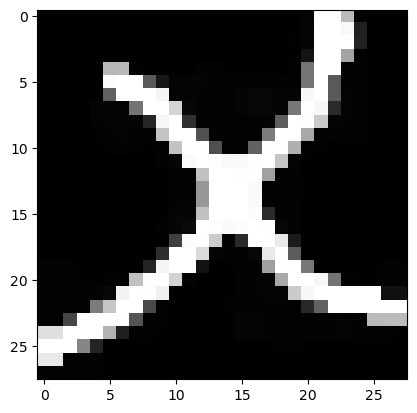

In [7]:
import random
# test = np.array(x_train[0])
N = random.randint(1, 10000)
test = x_train[N].reshape(28, 28, 1)
plt.imshow(test, cmap='gray')
print(t_train[N])

Normalize the data

In [8]:
# Normalization of validating data: shape from (3820, 28, 28) to (3820, 1, 28, 28)
x_vali = torch.unsqueeze(x_vali, dim=1).type(torch.FloatTensor)/255

# Normalization of training data: shape from (153280, 28, 28) to (153280, 1, 28, 28)
x_train = torch.unsqueeze(x_train, dim=1).type(torch.FloatTensor)/255

t_train = t_train.type(torch.LongTensor)
t_vali = t_vali.type(torch.LongTensor)

In [9]:
print(x_vali.shape)

torch.Size([2720, 1, 28, 28])


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#### Designing the Convolutional Neural Networks

In [11]:
# Parameters
EPOCHS = 50
BATCH_SIZE = 136
LR = 0.0001              # learning rate

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=32,            # n_filters
                kernel_size=3,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # padding
            ),                              
            nn.BatchNorm2d(32),             # normalization the data
            nn.ReLU(),                      # activation function
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area
            nn.Dropout2d(p=0.3)             # drop out 10% of data
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(32, 64, 3, 1, 2),     
            nn.BatchNorm2d(64),
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
            nn.Dropout2d(p=0.3)
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(64, 128, 3, 1, 2),    
            nn.BatchNorm2d(128),
            nn.ReLU(),                      
            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.3)
        )
        self.conv4 = nn.Sequential(         
            nn.Conv2d(128, 128, 3, 1, 2),     
            nn.BatchNorm2d(128),
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
            nn.Dropout2d(p=0.3)
        )
        # self.conv5 = nn.Sequential(         
        #     nn.Conv2d(64, 64, 3, 1, 2),     
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),                      
        #     nn.MaxPool2d(2),                
        #     nn.Dropout2d(p=0.1),
        # )

        self.out1 = nn.Sequential(nn.Linear(1152, 1000), 
                                 nn.ReLU(),
                                 nn.Dropout(p=0.3))
        self.out2 = nn.Sequential(nn.Linear(1000 , 500),  
                                 nn.ReLU(),
                                 nn.Dropout(p=0.3))
        self.out3 = nn.Sequential(nn.Linear(500 , 17))  # last fully connected layer,  output 17 classes

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # x = self.conv5(x)
        x = x.view(x.size(0), -1)  # flatten the output of conv2 to (BATCH_SIZE, 64 * 3 * 3)
        # Linear layers          
        output = self.out1(x)
        output = self.out2(output)
        output = self.out3(output)
        return output, x

# Activate the class CNN
cnn = CNN().to(device);

# Determining the optimizer and loss function
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # cross entropy loss


#### Training and Validating the model

In [12]:
# create the empty array for collecting the accuracy and average loss values
acc_train_list = []
acc_vali_list = []
loss_train_avg_list = []
loss_vali_avg_list = []
for epoch in range(EPOCHS):
    # create the empty array for collecting the prediction labels and loss values for each epoch
    pred_y_train = np.array([])
    pred_y_vali = np.array([])
    loss_train_list = np.array([])
    loss_vali_list = np.array([])

    for step in range(1, int((len(x_train)/BATCH_SIZE)+1)):

        # define the variables
        batch_x_train = x_train[BATCH_SIZE*(step-1):BATCH_SIZE*step]
        batch_t_train = t_train[BATCH_SIZE*(step-1):BATCH_SIZE*step]

        # send data to gpu
        batch_x_train = batch_x_train.to(device)
        batch_t_train = batch_t_train.to(device)

        # start training
        cnn.train()

        # Forward pass
        train_output = cnn(batch_x_train)[0]                    # cnn output
        loss_train = loss_func(train_output, batch_t_train)     # cross entropy loss

        # Backward Pass and optimize
        optimizer.zero_grad()               # clear gradients for this training step
        loss_train.backward()               # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
        
        _ , prediction_train = torch.max(train_output, 1)

        # append to empty created array
        pred_y_train = np.append(pred_y_train, prediction_train.cpu().numpy())
        loss_train_list = np.append(loss_train_list, loss_train.cpu().detach().numpy())

        # send data back to cpu for saving space memory
        batch_x_train = batch_x_train.to('cpu')
        batch_t_train = batch_t_train.to('cpu')

    # validating the model
    with torch.no_grad():
        # Deactivate some modules that we need in training but do not need in validating the model
        # such as BatchNorm or Dropout modules
        cnn.eval()
        
        for step_2 in range(1, int((len(x_vali)/BATCH_SIZE)+1)):
            # define variable
            batch_x_vali = x_vali[BATCH_SIZE*(step_2-1):BATCH_SIZE*step_2]
            batch_t_vali = t_vali[BATCH_SIZE*(step_2-1):BATCH_SIZE*step_2]

            # send data to gpu
            batch_x_vali = batch_x_vali.to(device)
            batch_t_vali = batch_t_vali.to(device)

            # find the output
            vali_output = cnn(batch_x_vali)[0]

            loss_vali = loss_func(vali_output, batch_t_vali)

            # find the maximum value from output so that 
            _ , prediction_vali = torch.max(vali_output, 1)
            
            # append to empty created array
            pred_y_vali = np.append(pred_y_vali, prediction_vali.cpu().numpy())
            loss_vali_list = np.append(loss_vali_list, loss_vali.cpu().numpy())

            # send data back to cpu
            batch_x_vali = batch_x_vali.to('cpu')
            batch_t_vali = batch_t_vali.to('cpu')

    # calculate the average value of the train and validation loss
    loss_vali_avg = np.average(loss_vali_list)
    loss_vali_avg_list.append(loss_vali_avg)
    loss_train_avg = np.average(loss_train_list)
    loss_train_avg_list.append(loss_train_avg)
    
    # calculate the accuracy per each epoch
    accuracy_vali = accuracy_score(t_vali,pred_y_vali)
    acc_vali_list.append(accuracy_vali)

    accuracy_train = accuracy_score(t_train,pred_y_train)
    acc_train_list.append(accuracy_train)           

    # print a result
    print('Epoch: ', epoch + 1, '| train loss: %.4f' % loss_train_avg, "| validation loss: %.4f" % loss_vali_avg, '| validation accuracy: %.5f' % accuracy_vali)

Epoch:  1 | train loss: 2.5448 | validation loss: 1.7639 | validation accuracy: 0.55257
Epoch:  2 | train loss: 1.4043 | validation loss: 0.7029 | validation accuracy: 0.81691
Epoch:  3 | train loss: 0.7957 | validation loss: 0.4027 | validation accuracy: 0.88456
Epoch:  4 | train loss: 0.5611 | validation loss: 0.2913 | validation accuracy: 0.91728
Epoch:  5 | train loss: 0.4335 | validation loss: 0.2286 | validation accuracy: 0.93934
Epoch:  6 | train loss: 0.3593 | validation loss: 0.1846 | validation accuracy: 0.95037
Epoch:  7 | train loss: 0.3076 | validation loss: 0.1625 | validation accuracy: 0.95551
Epoch:  8 | train loss: 0.2759 | validation loss: 0.1411 | validation accuracy: 0.96103
Epoch:  9 | train loss: 0.2463 | validation loss: 0.1378 | validation accuracy: 0.96066
Epoch:  10 | train loss: 0.2274 | validation loss: 0.1190 | validation accuracy: 0.96912
Epoch:  11 | train loss: 0.2070 | validation loss: 0.1150 | validation accuracy: 0.97206
Epoch:  12 | train loss: 0.191

#### Plotting the accuracy

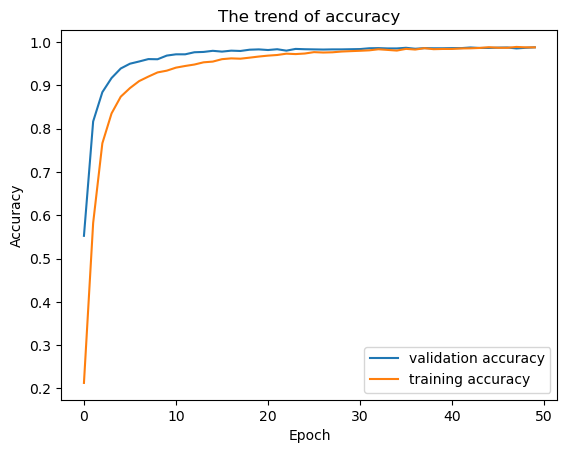

In [13]:
plt.figure()
plt.plot(acc_vali_list, label="validation accuracy")
plt.plot(acc_train_list, label = "training accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("The trend of accuracy")
plt.show();

#### Plotting train and validation loss

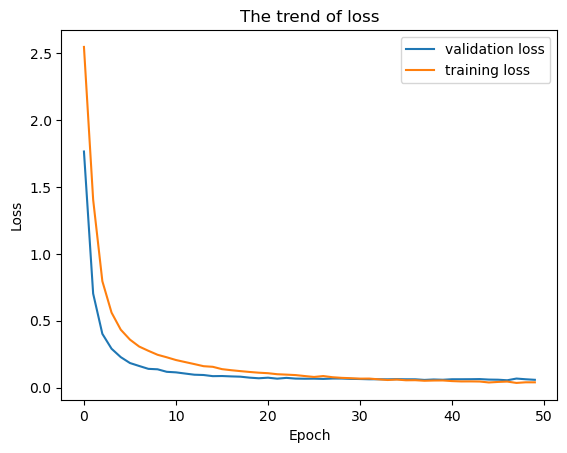

In [14]:
plt.figure()
plt.plot(loss_vali_avg_list, label="validation loss")
plt.plot(loss_train_avg_list, label = "training loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("The trend of loss");

#### Training the whole data with parameters from validating section

In [15]:
# reshape the dataset
data = torch.unsqueeze(data, dim=1).type(torch.FloatTensor)/255
labels = labels.type(torch.LongTensor)

# training the model
for epoch in range(EPOCHS):
    for step in range(1, int((len(data)/BATCH_SIZE)+1)):

        # define the variables
        batch_data = data[BATCH_SIZE*(step-1):BATCH_SIZE*step]
        batch_labels = labels[BATCH_SIZE*(step-1):BATCH_SIZE*step]

        # send data to gpu
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        # start training
        cnn.train()

        # Forward pass
        output = cnn(batch_data)[0]                 # cnn output
        loss = loss_func(output, batch_labels)      # cross entropy loss

        # Backward Pass and optimize
        optimizer.zero_grad()                       # clear gradients for this training step
        loss.backward()                             # backpropagation, compute gradients
        optimizer.step()                            # apply gradients

        # send data back to cpu for saving space memory
        batch_data = batch_data.to('cpu')
        batch_labels = batch_labels.to('cpu')

#### Saving the weights

In [16]:
torch.save(cnn.state_dict(), 'model10.pth')